# Data Cleaning and Processing

In [174]:
import pandas
import random

n = 499999 #27300000 #number of records in file
s = 200000 #desired sample size
filename = "data.txt"
skip = sorted(random.sample(range(n),n-s))
#df = pandas.read_csv(filename, skiprows=skip)

In [175]:
skip = skip + list(range(500000, 27300000))

In [176]:
# takes a minite to run
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
# chunks = pd.read_csv("EastCoastDatathonMaterials/nyc_bikeshare.csv", chunksize=10000)
# i = 0
# for chunk in chunks:
#     i += 1    
#     if i == 150: 
#         NYC_bikeshare = chunk
#         break
NYC_bikeshare = pd.read_csv("EastCoastDatathonMaterials/nyc_bikeshare.csv", skiprows=skip)
NYC_bikeshare

,tripduration,starttime,stoptime,start_station_id,end_station_id,bikeid,usertype,birthyear,gender
0,1521,06-01-13 00:01:22,06-01-13 00:26:43,2008.0,310.0,15567,1.0,1983.0,1
1,2028,06-01-13 00:01:47,06-01-13 00:35:35,485.0,406.0,18445,0.0,NaN,0
2,1829,06-01-13 00:03:47,06-01-13 00:34:16,265.0,436.0,15234,1.0,1984.0,1
3,899,06-01-13 00:09:25,06-01-13 00:24:24,494.0,494.0,15539,1.0,1967.0,1
4,395,06-01-13 00:11:52,06-01-13 00:18:27,312.0,410.0,19477,1.0,1970.0,1
...,...,...,...,...,...,...,...,...,...
199995,385,08-08-13 13:31:47,08-08-13 13:38:12,301.0,335.0,19833,0.0,NaN,0
199996,378,08-08-13 13:31:51,08-08-13 13:38:09,450.0,488.0,20548,1.0,1976.0,1
199997,1090,08-08-13 13:32:03,08-08-13 13:50:13,511.0,265.0,20198,1.0,1982.0,1
199998,598,08-08-13 13:32:21,08-08-13 13:42:19,477.0,337.0,16505,1.0,1978.0,2


In [207]:
NYC_bikeshare.to_csv("raw_sampled_bike_trip.csv")

In [177]:
NYC_bikeshare.columns = ['tripduration', 'starttime', 'stoptime', 'start_station_id', 'end_station_id', 'bikeid', 'usertype', 'birthyear', 'gender']
NYC_bikeshare.columns

Index(['tripduration', 'starttime', 'stoptime', 'start_station_id',
       'end_station_id', 'bikeid', 'usertype', 'birthyear', 'gender'],
      dtype='object')

In [178]:
NYC_bikeshare['starttime'] = pd.to_datetime(NYC_bikeshare['starttime'])
NYC_bikeshare['stoptime'] = pd.to_datetime(NYC_bikeshare['stoptime'])

In [124]:
NYC_weather = pd.read_csv("EastCoastDatathonMaterials/weather.csv")
NYC_weather['DATE'] = pd.to_datetime(NYC_weather['DATE'])

/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13,14,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [125]:
NYC_weather_hourly = NYC_weather[NYC_weather['REPORT_TYPE'] == 'FM-15']
NYC_weather_hourly = NYC_weather_hourly[['DATE', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyPrecipitation', 'HourlyWindSpeed']]
NYC_weather_hourly.columns = ['Date', 'DewTemp', 'DryTemp', 'Precip', 'Wspeed']
NYC_bikeshare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
tripduration        10000 non-null int64
starttime           10000 non-null datetime64[ns]
stoptime            10000 non-null datetime64[ns]
start_station_id    10000 non-null float64
end_station_id      9940 non-null float64
bikeid              10000 non-null int64
usertype            10000 non-null float64
birthyear           7735 non-null float64
gender              10000 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3)
memory usage: 703.2 KB


In [127]:
def myfunc(date):
    return date.replace(microsecond=0,second=0,minute=0)
NYC_weather_hourly['Date'] = NYC_weather_hourly['Date'].apply(myfunc)

def checkweekday(date):
    return date.weekday()
NYC_weather_hourly['weekday'] = NYC_weather_hourly['Date'].apply(checkweekday)

cal = calendar()
holidays = cal.holidays(start=NYC_weather_hourly['Date'].min(), end=NYC_weather_hourly['Date'].max())

def checkholiday(date):
    return date.replace(hour=0) in holidays
NYC_weather_hourly['holiday'] = NYC_weather_hourly['Date'].apply(checkholiday)
# TODO: Add snow feature (0, 1) from daily data

In [179]:
NYC_bikeshare['DDay'] = NYC_bikeshare['starttime'].apply(myfunc)
num_trips = NYC_bikeshare.groupby(['DDay', 'usertype']).count()[['tripduration']]
num_trips.reset_index(inplace=True)
num_trips = num_trips.pivot(index='DDay', columns='usertype', values='tripduration')
num_trips.columns=['cust_cnt', 'subs_cnt']

trip_duration = NYC_bikeshare.groupby(['DDay', 'usertype']).sum()[['tripduration']]
trip_duration.reset_index(inplace=True)
trip_duration = trip_duration.pivot(index='DDay', columns='usertype', values='tripduration')
trip_duration.columns=['cust_dur', 'subs_dur']

In [180]:
# merge into NYC_weather_hourly
A = NYC_weather_hourly.set_index('Date')
mergeddf = A.merge(num_trips, left_index=True, right_index=True)
weather_cnt_dur = mergeddf.merge(trip_duration, left_index=True, right_index=True)

In [181]:
weather_cnt_dur.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1636 entries, 2013-06-01 00:00:00 to 2013-08-08 13:00:00
Data columns (total 10 columns):
DewTemp     1636 non-null object
DryTemp     1636 non-null object
Precip      1636 non-null float64
Wspeed      1507 non-null float64
weekday     1636 non-null int64
holiday     1636 non-null bool
cust_cnt    1571 non-null float64
subs_cnt    1621 non-null float64
cust_dur    1571 non-null float64
subs_dur    1621 non-null float64
dtypes: bool(1), float64(6), int64(1), object(2)
memory usage: 129.4+ KB


In [268]:
dailyData = weather_cnt_dur.copy()
weather_cnt_dur

,DewTemp,DryTemp,Precip,Wspeed,weekday,holiday,cust_cnt,subs_cnt,cust_dur,subs_dur
2013-06-01 00:00:00,64.0,77,0.0,5.0,5,False,2.0,23.0,3650.0,139967.0
2013-06-01 01:00:00,65.0,76,0.0,NaN,5,False,2.0,10.0,2332.0,15257.0
2013-06-01 02:00:00,65.0,76,0.0,5.0,5,False,3.0,4.0,5696.0,2194.0
2013-06-01 03:00:00,65.0,74,0.0,0.0,5,False,1.0,6.0,620.0,4908.0
2013-06-01 04:00:00,65.0,74,0.0,6.0,5,False,NaN,1.0,NaN,514.0
...,...,...,...,...,...,...,...,...,...,...
2013-08-08 09:00:00,70.0,76,0.0,5.0,3,False,21.0,252.0,22862.0,193599.0
2013-08-08 10:00:00,70.0,78,0.0,3.0,3,False,19.0,140.0,29085.0,150174.0
2013-08-08 11:00:00,71.0,77,0.0,6.0,3,False,27.0,98.0,36494.0,74727.0
2013-08-08 12:00:00,71.0,79,0.0,3.0,3,False,42.0,147.0,52101.0,125946.0


In [203]:
weather_cnt_dur.to_csv('sample_agg_weather_bike_data.csv')

# EDA begins here

In [269]:
dailyData = dailyData.reset_index()

In [270]:
dailyData['datetime'] = dailyData['index'] 
dailyData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 12 columns):
index       1636 non-null datetime64[ns]
DewTemp     1636 non-null object
DryTemp     1636 non-null object
Precip      1636 non-null float64
Wspeed      1507 non-null float64
weekday     1636 non-null int64
holiday     1636 non-null bool
cust_cnt    1571 non-null float64
subs_cnt    1621 non-null float64
cust_dur    1571 non-null float64
subs_dur    1621 non-null float64
datetime    1636 non-null datetime64[ns]
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 142.3+ KB


In [271]:
def dateextract(date):
    return date.date()

def hourextract(date):
    return date.hour
dailyData["date"] = dailyData['datetime'].apply(dateextract)
dailyData["hour"] = dailyData['datetime'].apply(hourextract)
dailyData["month"] = dailyData['datetime'].apply(lambda x: x.month)
dailyData



,index,DewTemp,DryTemp,Precip,Wspeed,weekday,holiday,cust_cnt,subs_cnt,cust_dur,subs_dur,datetime,date,hour,month
0,2013-06-01 00:00:00,64.0,77,0.0,5.0,5,False,2.0,23.0,3650.0,139967.0,2013-06-01 00:00:00,2013-06-01,0,6
1,2013-06-01 01:00:00,65.0,76,0.0,NaN,5,False,2.0,10.0,2332.0,15257.0,2013-06-01 01:00:00,2013-06-01,1,6
2,2013-06-01 02:00:00,65.0,76,0.0,5.0,5,False,3.0,4.0,5696.0,2194.0,2013-06-01 02:00:00,2013-06-01,2,6
3,2013-06-01 03:00:00,65.0,74,0.0,0.0,5,False,1.0,6.0,620.0,4908.0,2013-06-01 03:00:00,2013-06-01,3,6
4,2013-06-01 04:00:00,65.0,74,0.0,6.0,5,False,NaN,1.0,NaN,514.0,2013-06-01 04:00:00,2013-06-01,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,2013-08-08 09:00:00,70.0,76,0.0,5.0,3,False,21.0,252.0,22862.0,193599.0,2013-08-08 09:00:00,2013-08-08,9,8
1632,2013-08-08 10:00:00,70.0,78,0.0,3.0,3,False,19.0,140.0,29085.0,150174.0,2013-08-08 10:00:00,2013-08-08,10,8
1633,2013-08-08 11:00:00,71.0,77,0.0,6.0,3,False,27.0,98.0,36494.0,74727.0,2013-08-08 11:00:00,2013-08-08,11,8
1634,2013-08-08 12:00:00,71.0,79,0.0,3.0,3,False,42.0,147.0,52101.0,125946.0,2013-08-08 12:00:00,2013-08-08,12,8


In [272]:
dailyData['cust_cnt'] = dailyData['cust_cnt'].fillna(0)
dailyData['subs_cnt'] = dailyData['subs_cnt'].fillna(0)
dailyData['cust_dur'] = dailyData['cust_dur'].fillna(0)
dailyData['subs_dur'] = dailyData['subs_dur'].fillna(0)
dailyData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 15 columns):
index       1636 non-null datetime64[ns]
DewTemp     1636 non-null object
DryTemp     1636 non-null object
Precip      1636 non-null float64
Wspeed      1507 non-null float64
weekday     1636 non-null int64
holiday     1636 non-null bool
cust_cnt    1636 non-null float64
subs_cnt    1636 non-null float64
cust_dur    1636 non-null float64
subs_dur    1636 non-null float64
datetime    1636 non-null datetime64[ns]
date        1636 non-null object
hour        1636 non-null int64
month       1636 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(3), object(3)
memory usage: 180.7+ KB


In [273]:
dailyData['total_cnt'] = dailyData['cust_cnt'] + dailyData['subs_cnt']
dailyData['total_dur'] = dailyData['cust_dur'] + dailyData['subs_dur']
dailyData['working_day'] = (dailyData['weekday'].astype('int') < 5) & (dailyData['holiday'].astype('int') == 0)

In [274]:
category_var_list = ['hour', 'weekday', 'month', 'working_day']
for var in category_var_list:
    dailyData[var] = dailyData[var].astype("category")
dailyData  = dailyData.drop(["datetime", "index"],axis=1)
dailyData['DewTemp'] = dailyData['DewTemp'].astype('float')
dailyData['DryTemp'] = dailyData['DryTemp'].astype('float')


dailyData.dropna(inplace=True)
dailyData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1507 entries, 0 to 1634
Data columns (total 16 columns):
DewTemp        1507 non-null float64
DryTemp        1507 non-null float64
Precip         1507 non-null float64
Wspeed         1507 non-null float64
weekday        1507 non-null category
holiday        1507 non-null bool
cust_cnt       1507 non-null float64
subs_cnt       1507 non-null float64
cust_dur       1507 non-null float64
subs_dur       1507 non-null float64
date           1507 non-null object
hour           1507 non-null category
month          1507 non-null category
total_cnt      1507 non-null float64
total_dur      1507 non-null float64
working_day    1507 non-null category
dtypes: bool(1), category(4), float64(10), object(1)
memory usage: 150.0+ KB


In [217]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

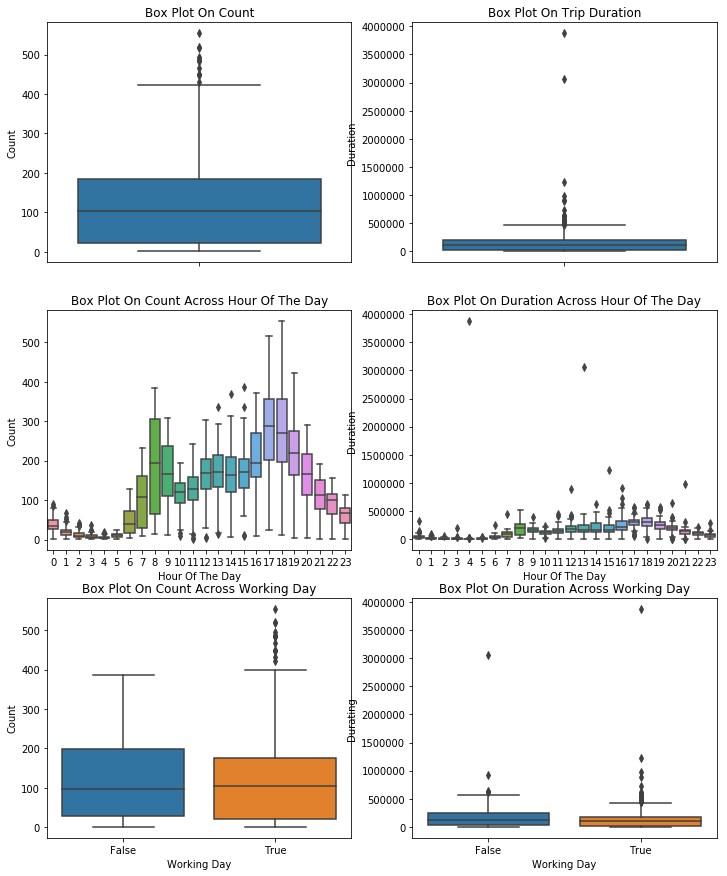

In [280]:


fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(12, 15)
sn.boxplot(data=dailyData,y="total_cnt",orient="v",ax=axes[0][0])
sn.boxplot(data=dailyData,y="total_dur",orient="v",ax=axes[0][1])
sn.boxplot(data=dailyData,y="total_cnt",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=dailyData,y="total_dur",x="hour", orient="v",ax=axes[1][1])
sn.boxplot(data=dailyData,y="total_cnt",x="working_day",orient="v",ax=axes[2][0])
sn.boxplot(data=dailyData,y="total_dur",x="working_day", orient="v",ax=axes[2][1])


axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(ylabel='Duration',title="Box Plot On Trip Duration")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Hour Of The Day', ylabel='Duration',title="Box Plot On Duration Across Hour Of The Day")



axes[2][0].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")
axes[2][1].set(xlabel='Working Day', ylabel='Durating',title="Box Plot On Duration Across Working Day")


plt.show()

In [284]:
dailyData['subs_avg_dur'] = dailyData['subs_dur']/dailyData['subs_cnt']
dailyData['cust_avg_dur'] = dailyData['cust_dur']/dailyData['cust_cnt']

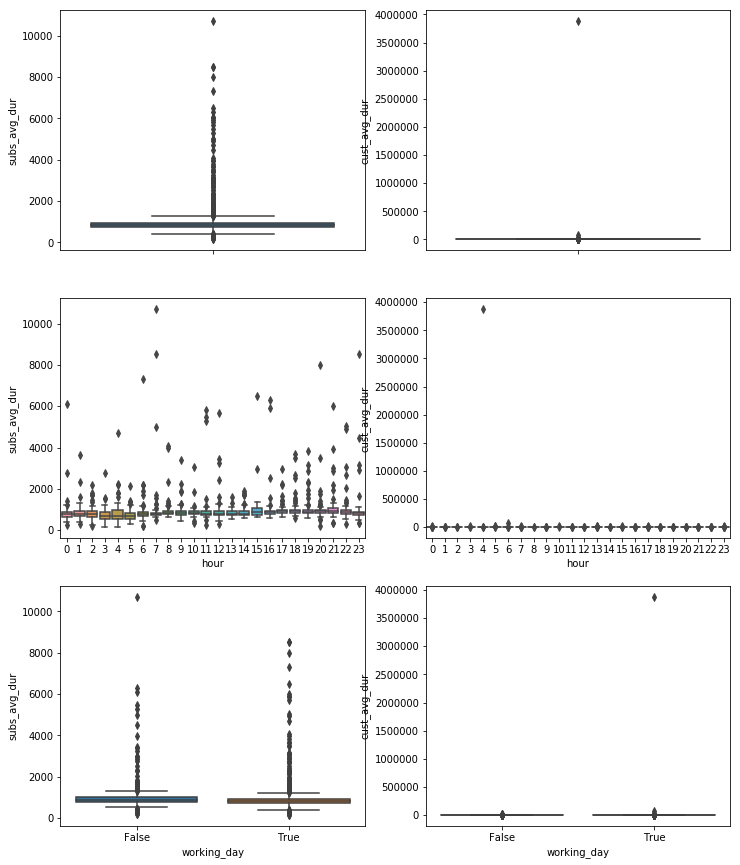

In [289]:
fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(12, 15)

sn.boxplot(data=dailyData,y="subs_avg_dur",orient="v",ax=axes[0][0])
sn.boxplot(data=dailyData,y="cust_avg_dur",orient="v",ax=axes[0][1])

sn.boxplot(data=dailyData,y="subs_avg_dur", x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=dailyData,y="cust_avg_dur", x="hour", orient="v",ax=axes[1][1])

sn.boxplot(data=dailyData,y="subs_avg_dur", x="working_day",orient="v",ax=axes[2][0])
sn.boxplot(data=dailyData,y="cust_avg_dur", x="working_day", orient="v",ax=axes[2][1])

In [317]:
# remove outlier and replot
dailyDataWithoutOutliers = dailyData[
    (np.abs(dailyData["total_cnt"]-dailyData["total_cnt"].mean())<=(3*dailyData["total_cnt"].std()))
    & (np.abs(dailyData["total_dur"]-dailyData["total_dur"].mean())<=(3*dailyData["total_dur"].std()))
    & (dailyData['subs_avg_dur'] < 2000) & (dailyData['cust_avg_dur'] < 5000)] 






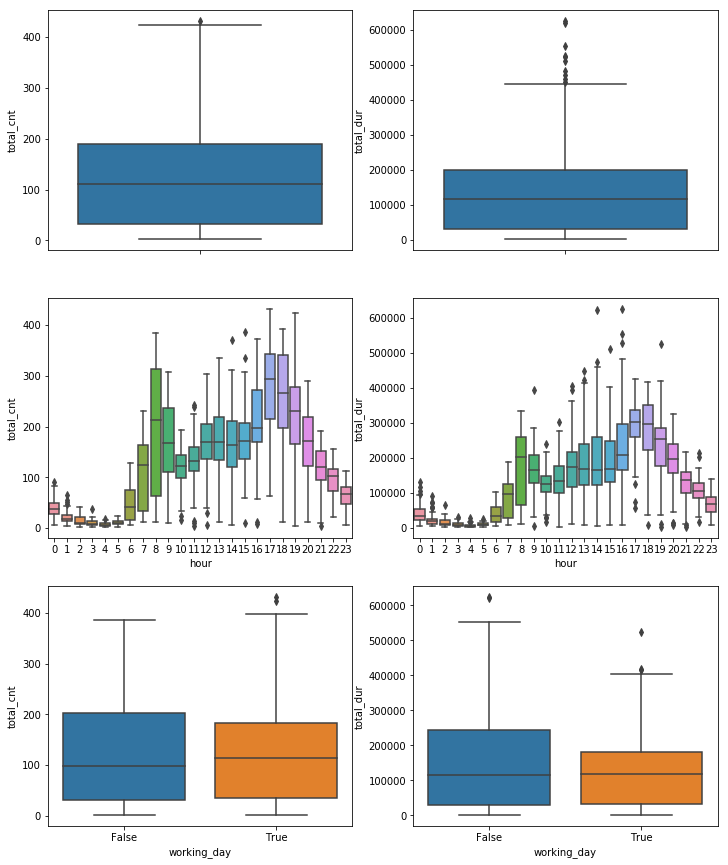

In [322]:
fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(12, 15)
sn.boxplot(data=dailyDataWithoutOutliers,y="total_cnt",orient="v",ax=axes[0][0])
sn.boxplot(data=dailyDataWithoutOutliers,y="total_dur",orient="v",ax=axes[0][1])
sn.boxplot(data=dailyDataWithoutOutliers,y="total_cnt",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=dailyDataWithoutOutliers,y="total_dur",x="hour", orient="v",ax=axes[1][1])
sn.boxplot(data=dailyDataWithoutOutliers,y="total_cnt",x="working_day",orient="v",ax=axes[2][0])
sn.boxplot(data=dailyDataWithoutOutliers,y="total_dur",x="working_day", orient="v",ax=axes[2][1])

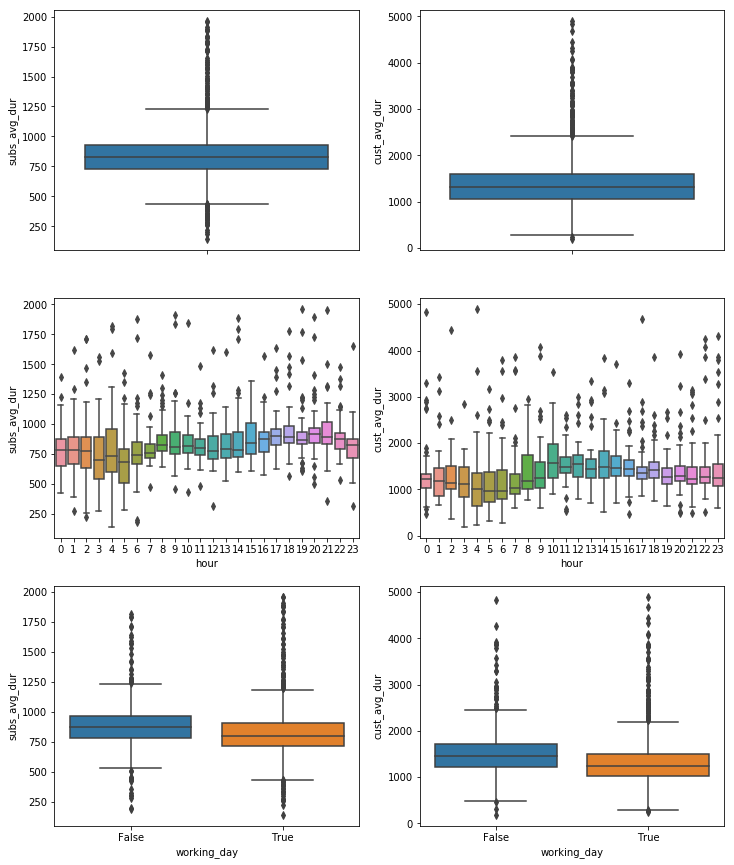

In [320]:
fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(12, 15)

sn.boxplot(data=dailyDataWithoutOutliers,y="subs_avg_dur",orient="v",ax=axes[0][0])
sn.boxplot(data=dailyDataWithoutOutliers,y="cust_avg_dur",orient="v",ax=axes[0][1])

sn.boxplot(data=dailyDataWithoutOutliers,y="subs_avg_dur", x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=dailyDataWithoutOutliers,y="cust_avg_dur", x="hour", orient="v",ax=axes[1][1])

sn.boxplot(data=dailyDataWithoutOutliers,y="subs_avg_dur", x="working_day",orient="v",ax=axes[2][0])
sn.boxplot(data=dailyDataWithoutOutliers,y="cust_avg_dur", x="working_day", orient="v",ax=axes[2][1])

In [323]:
dailyData.columns

Index(['DewTemp', 'DryTemp', 'Precip', 'Wspeed', 'weekday', 'holiday',
       'cust_cnt', 'subs_cnt', 'cust_dur', 'subs_dur', 'date', 'hour', 'month',
       'total_cnt', 'total_dur', 'working_day', 'subs_avg_dur',
       'cust_avg_dur'],
      dtype='object')

In [ ]:
corrMatt = dailyData[["DewTemp","DryTemp","Precip","Wspeed","","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

In [ ]:
#####################
# Useless code
#####################
# construct idea 1 dataframe
# start_time = max(np.min(NYC_bikeshare['starttime']),np.min(NYC_weather['DATE'])).replace(microsecond=0,second=0,minute=0)
# end_time = min(np.max(NYC_bikeshare['starttime']), np.max(NYC_weather['DATE'])).replace(microsecond=0,second=0,minute=0) + timedelta(hours=1)
# for testing:
start_time = min(np.min(NYC_bikeshare['starttime']),np.min(NYC_weather['DATE'])).replace(microsecond=0,second=0,minute=0)
end_time = max(np.max(NYC_bikeshare['starttime']), np.max(NYC_weather['DATE'])).replace(microsecond=0,second=0,minute=0) + timedelta(hours=1)
a = pd.date_range(start=start_time, end=end_time, freq='H')